In [10]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
import seaborn as sns
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.settings.figdir = 'figures'  # Directory to save figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6)) 

**Util function for feature embeddings**

## Step 1: Initialize data

In [11]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'pbmc68k' / 'pbmc68k_train.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['celltype'],
                    'conditioning_covariate': 'celltype',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
n_cat = len(dataset.id2cov["celltype"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [12]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 100],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_train_autoencoder_pbmc68k_whole_genome/97f9b5ed-0ed4-4149-a6cd-2d06195eba61/checkpoints/epoch_19.ckpt"

In [13]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)
encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Step 3: Initialize FM model

In [14]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

In [15]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_fm_resnet_autoencoder_pbmc68k_whole_genome/3c2c4b63-d451-4c0b-946b-54f899c7b145/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [16]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["celltype"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 0.8103,  1.1895, -0.5562,  ..., -1.6423, -0.8195, -1.1978],
        [ 0.8660,  1.9960, -0.1700,  ..., -0.8324,  0.6274,  0.5242],
        [-0.0488, -0.6265,  0.9520,  ..., -1.3586,  1.6835,  0.7545],
        ...,
        [-0.4768,  0.3862, -0.8997,  ..., -0.6096,  1.8491,  0.4936],
        [ 0.5293,  2.0938,  0.2356,  ...,  0.1520,  0.5077, -1.3874],
        [-0.8259, -0.2819, -0.9324,  ..., -0.0664,  0.2586,  0.8978]],
       device='cuda:0', requires_grad=True)


In [17]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=9189, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=100, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
        

## Read original data 

In [18]:
adata_original = sc.read_h5ad(DATA_DIR / 'processed_full_genome' / 'pbmc68k' / 'pbmc68k_test.h5ad')
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)

In [19]:
adata_original

AnnData object with n_obs × n_vars = 19758 × 9189
    obs: 'celltype', 'size_factor'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells'
    uns: 'celltype_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [20]:
unique_classes = np.unique(adata_original.obs.celltype, return_counts=True)
unique_classes = dict(zip(unique_classes[0], unique_classes[1]))
unique_classes

{'CD14+ Monocyte': 823,
 'CD19+ B': 1732,
 'CD34+': 64,
 'CD4+ T Helper2': 21,
 'CD4+/CD25 T Reg': 1764,
 'CD4+/CD45RA+/CD25- Naive T': 561,
 'CD4+/CD45RO+ Memory': 939,
 'CD56+ NK': 2576,
 'CD8+ Cytotoxic T': 5864,
 'CD8+/CD45RA+ Naive Cytotoxic': 4820,
 'Dendritic': 594}

## Generate and save cells

In [21]:
num_indices = 19700

# Generate random dummy indices without replacement
X_generated_list = []
classes_str = []
for _ in tqdm(range(197)):
    num_indices =100
    index_range = adata_original.shape[0]
    
    # Generate random dummy indices without replacement
    indices = random.sample(range(index_range), num_indices)
    adata_indices = adata_original[indices]
    
    classes =  list(adata_indices.obs.celltype)
    classes_str += classes
    classes = torch.tensor([dataset.id2cov["celltype"][c] for  c in classes])

    log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()
    X_generated = generative_model.batched_sample(batch_size=10,
                                                repetitions=10,
                                                n_sample_steps=2, 
                                                covariate="celltype", 
                                                covariate_indices=classes, 
                                                log_size_factor=None)

    X_generated_list.append(X_generated.to("cpu"))

100%|██████████| 197/197 [03:05<00:00,  1.06it/s]


In [22]:
X_generated = torch.cat(X_generated_list, dim=0)

### Generate single condition

In [24]:
dataset.id2cov["celltype"]

{'CD14+ Monocyte': 0,
 'CD19+ B': 1,
 'CD34+': 2,
 'CD4+ T Helper2': 3,
 'CD4+/CD25 T Reg': 4,
 'CD4+/CD45RA+/CD25- Naive T': 5,
 'CD4+/CD45RO+ Memory': 6,
 'CD56+ NK': 7,
 'CD8+ Cytotoxic T': 8,
 'CD8+/CD45RA+ Naive Cytotoxic': 9,
 'Dendritic': 10}

In [128]:
# # Pick condition 
# condition_name = "CD56+ NK"
# condition_val = dataset.id2cov["celltype"][condition_name]
# adata_cond = adata_original[adata_original.obs.celltype==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()
# classes_str = [condition_name for _ in range(n_to_generate)]


# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=100, 
#                                         covariate="celltype", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated= X_generated.to("cpu")

In [129]:
# # Oversample
# condition_name = 'CD14+ Monocyte'
# condition_val = dataset.id2cov["celltype"][condition_name]
# adata_cond = adata_original[adata_original.obs.celltype==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()
# classes_str = [condition_name for _ in range(n_to_generate)]

# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda().repeat(1,1)

# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=100, 
#                                         covariate="celltype", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated_list= X_generated.to("cpu")

**Create adata and check plots**

In [25]:
adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated).cpu().numpy()))

adata_generated.obs["size_factor"] = adata_generated.X.sum(1)
adata_generated.obs["celltype"] = classes_str
adata_generated.obs["celltype"] = adata_generated.obs["celltype"].astype("category")
adata_generated.layers["X_counts"] = adata_generated.X.copy()

In [26]:
sc.pp.normalize_total(adata_generated, target_sum=1e4)
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


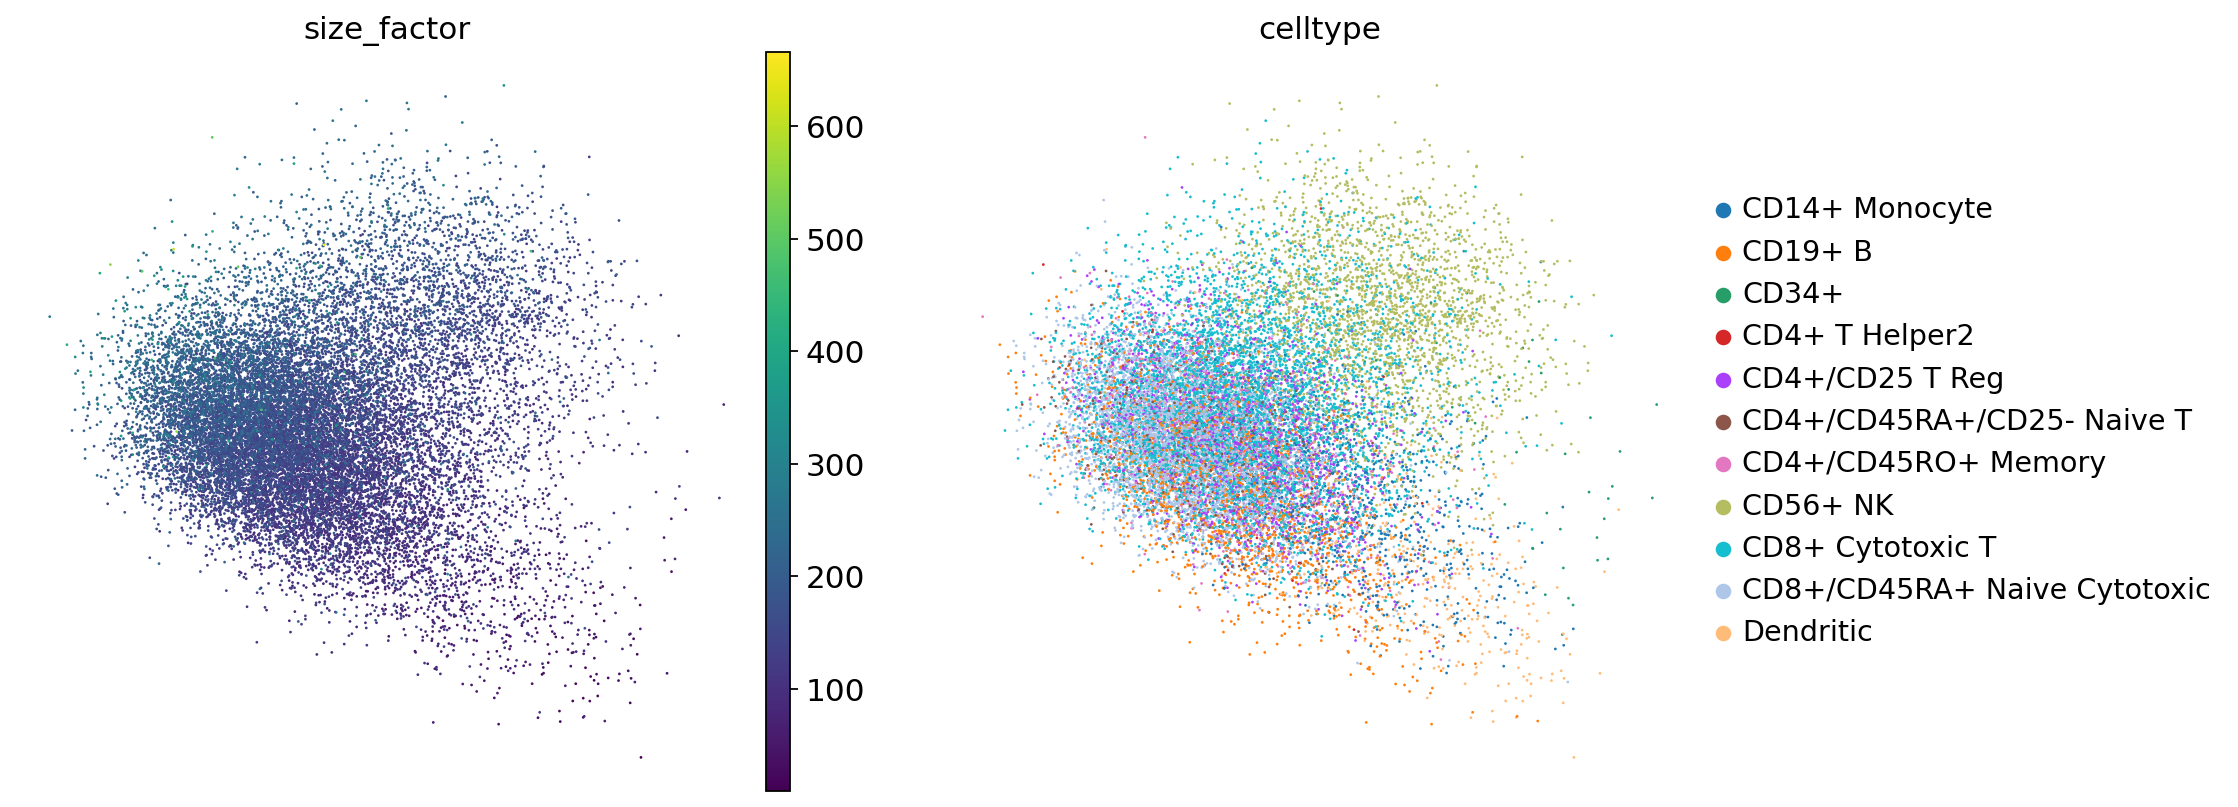

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


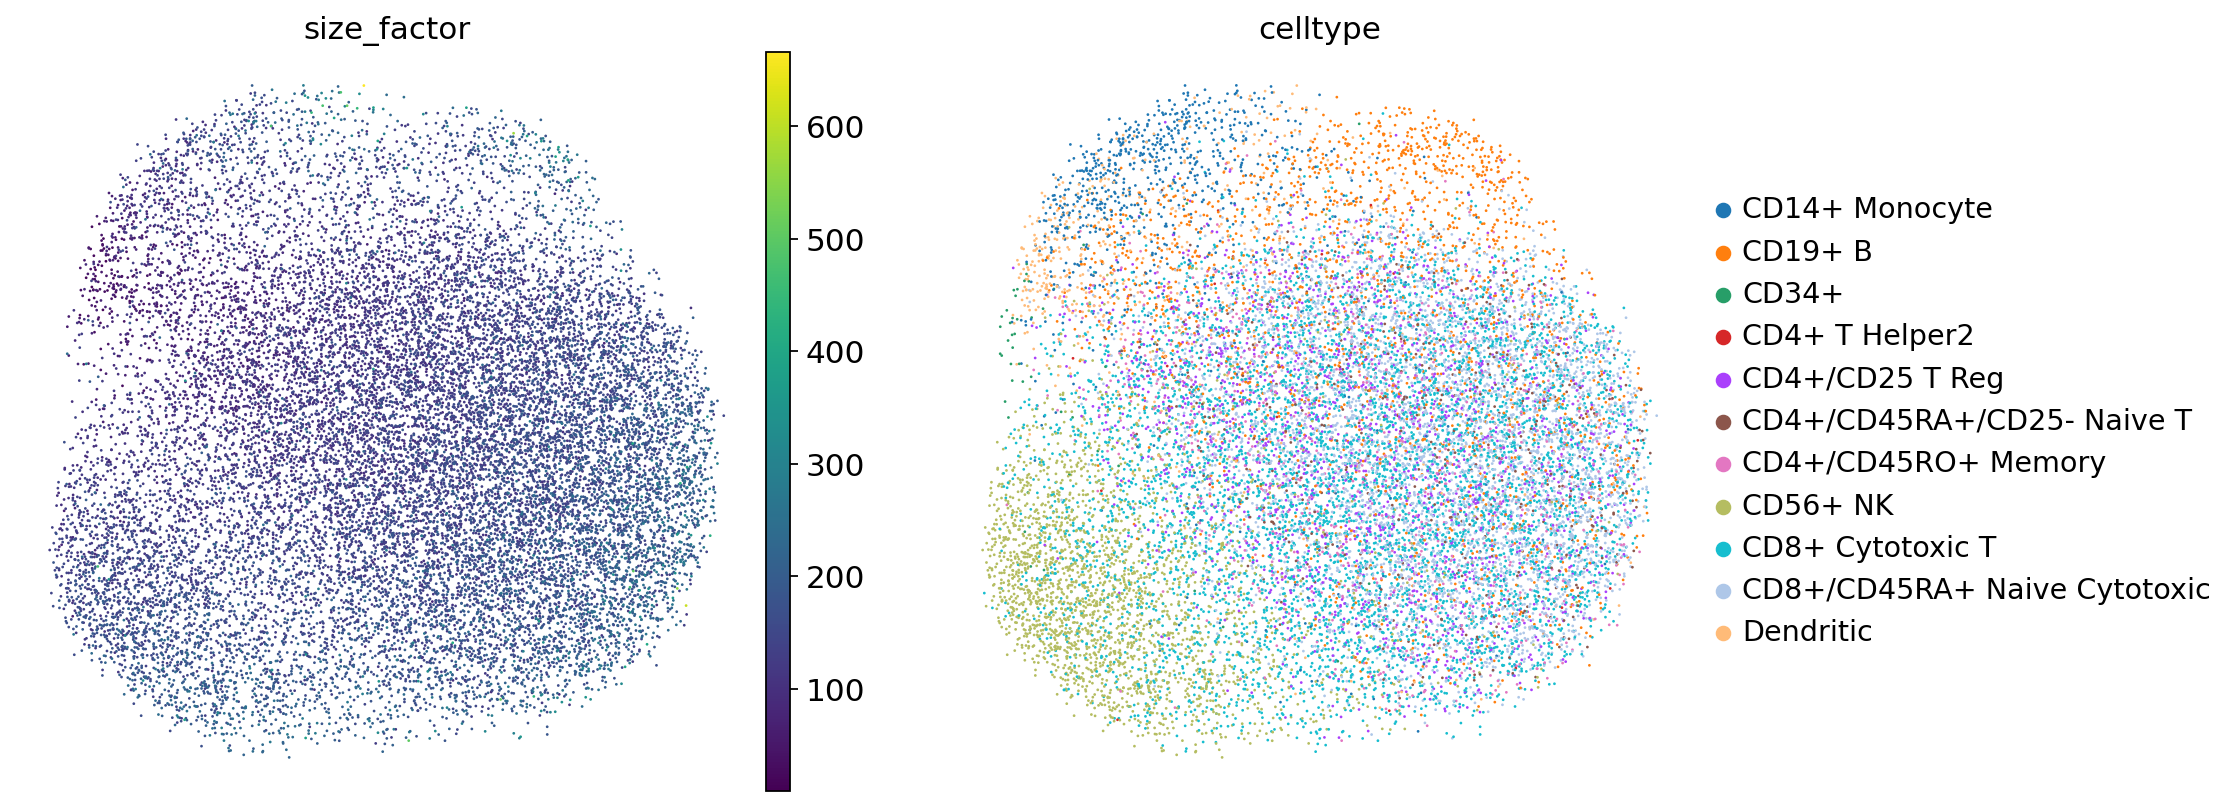

In [27]:
sc.pl.pca(adata_generated, color=["size_factor", "celltype"], annotate_var_explained=True)
sc.pl.umap(adata_generated, color=["size_factor", "celltype"])

In [133]:
# adata_generated.write_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/generated/pbmc68k.h5ad")

## Preprocess real data object

In [28]:
sc.pp.normalize_total(adata_original, target_sum=10000)
sc.pp.log1p(adata_original)
sc.tl.pca(adata_original)
sc.pp.neighbors(adata_original)
sc.tl.umap(adata_original)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


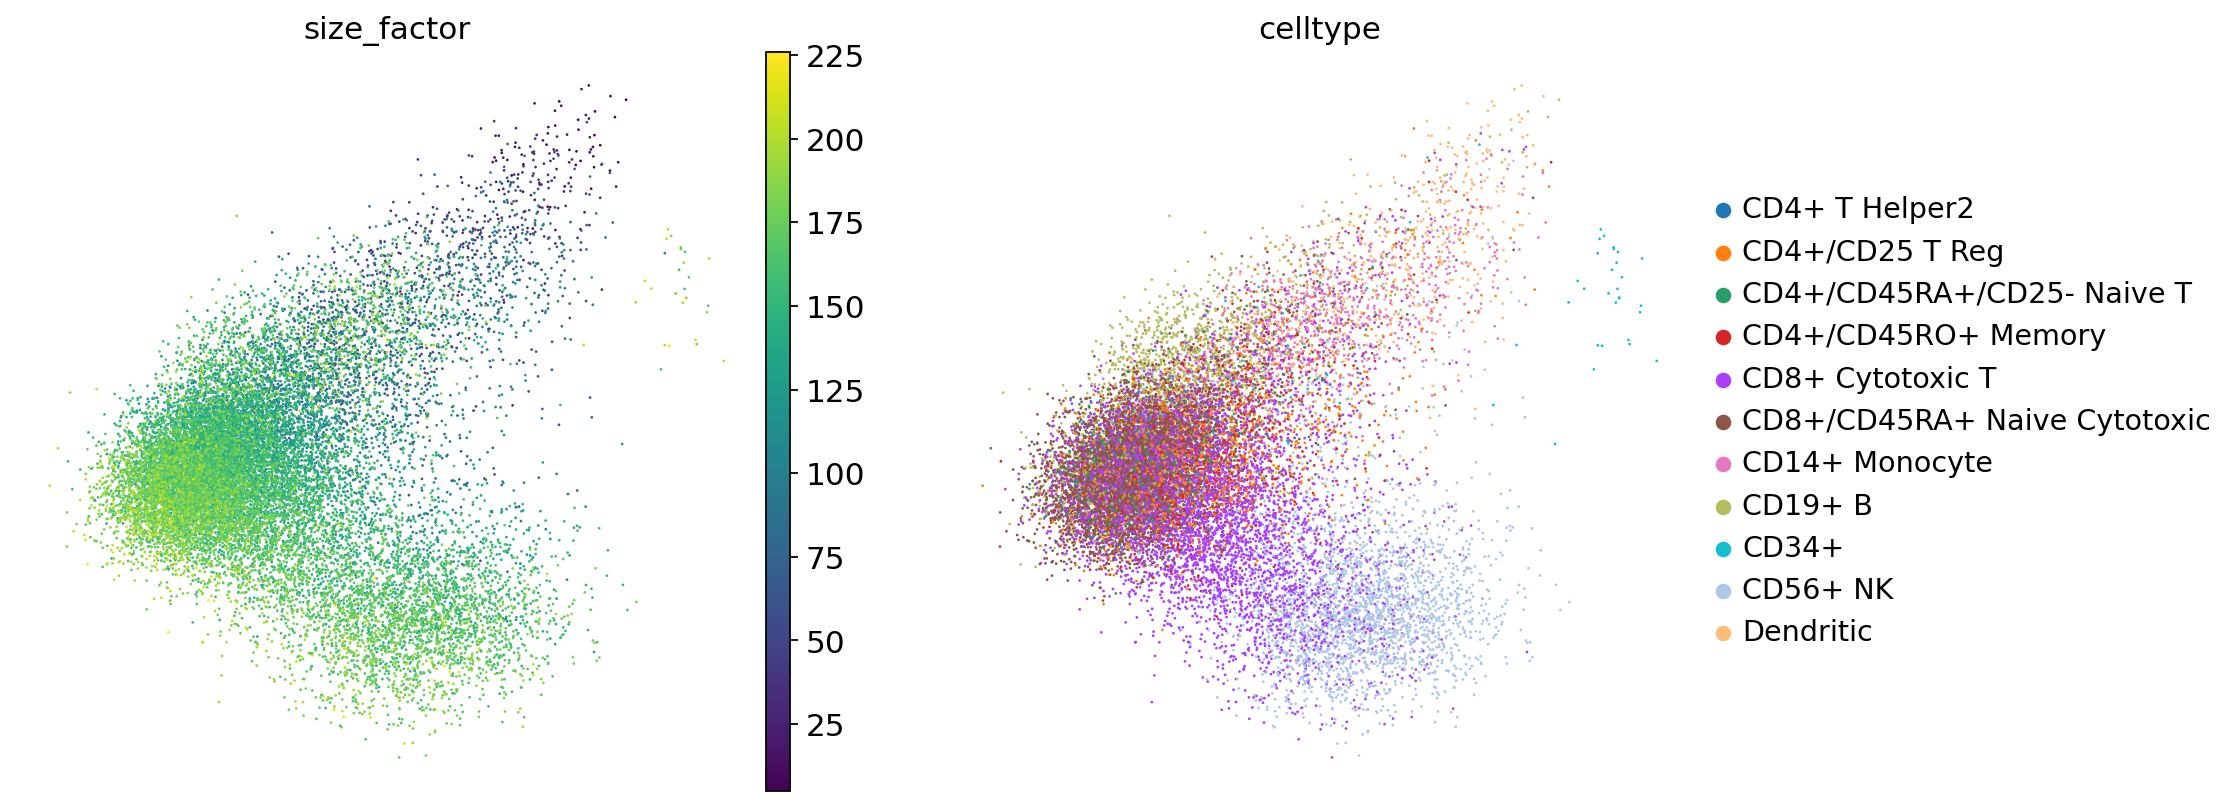

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


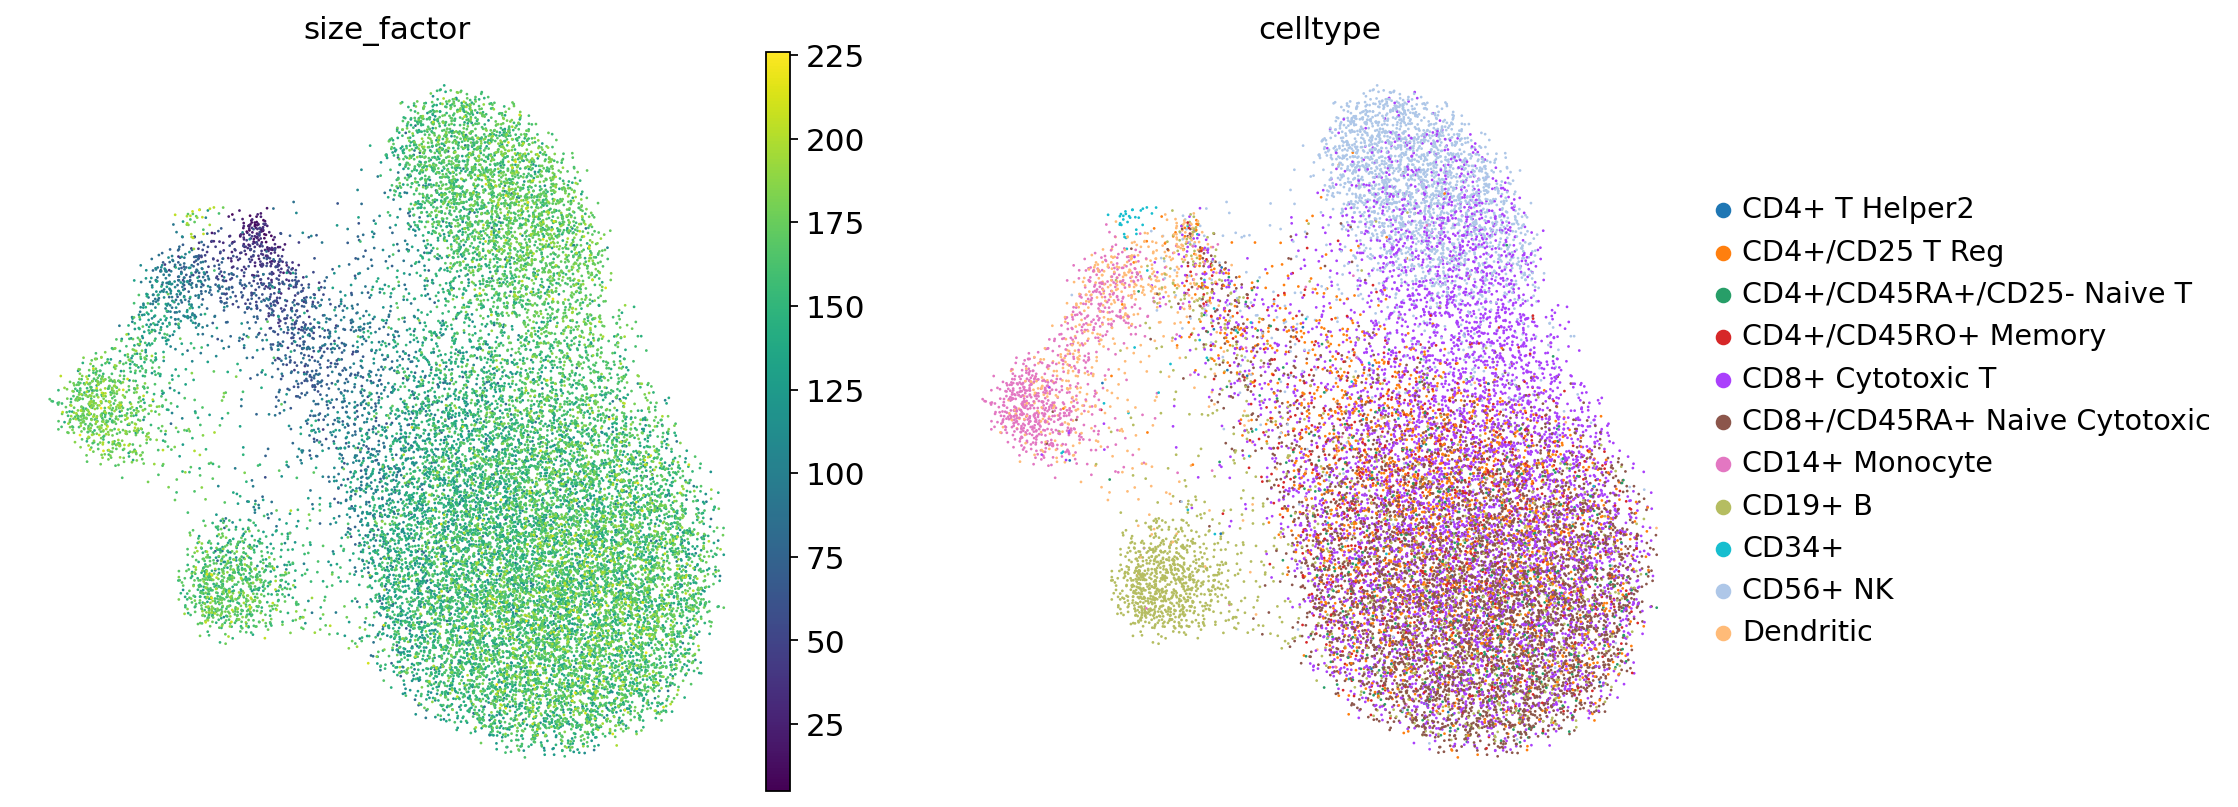

In [29]:
sc.pl.pca(adata_original, color=["size_factor", "celltype"], annotate_var_explained=True)
sc.pl.umap(adata_original, color=["size_factor", "celltype"])

## Merge and plot the generated and real data

In [30]:
dataset_type = ["Real" for _ in range(adata_original.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["celltype"] = list(adata_original.obs.celltype)+list(classes_str)

In [31]:
adata_merged = sc.AnnData(X=torch.cat([torch.tensor(adata_original.X.A), torch.tensor(adata_generated.X.A)], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [32]:
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


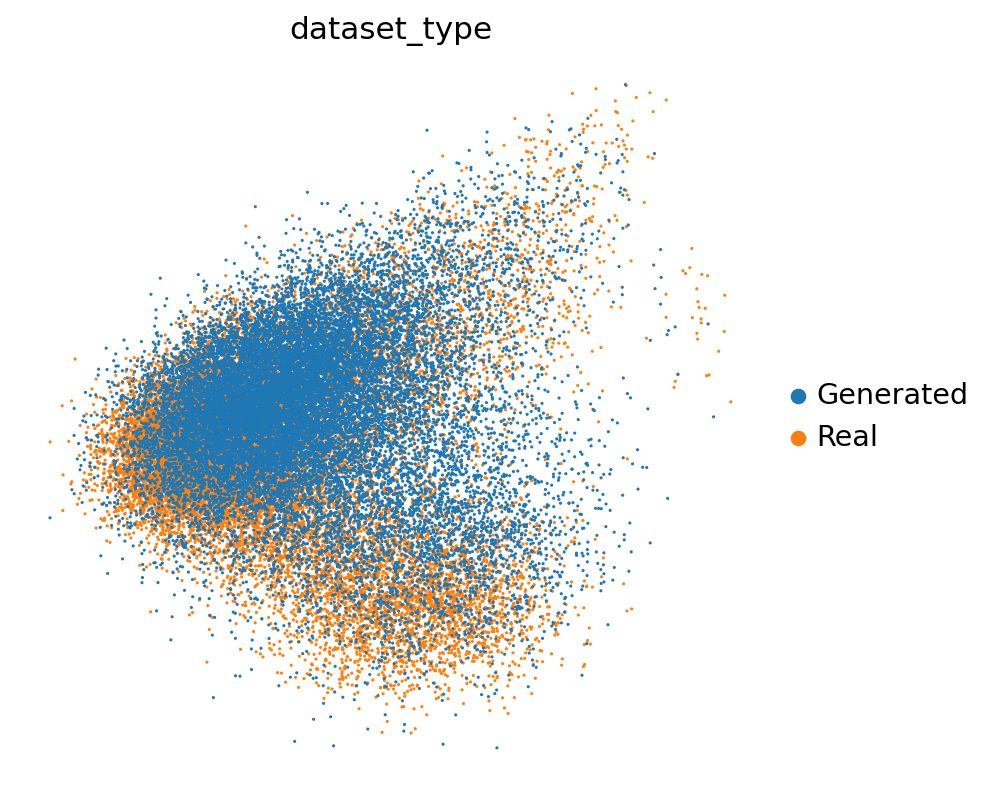

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


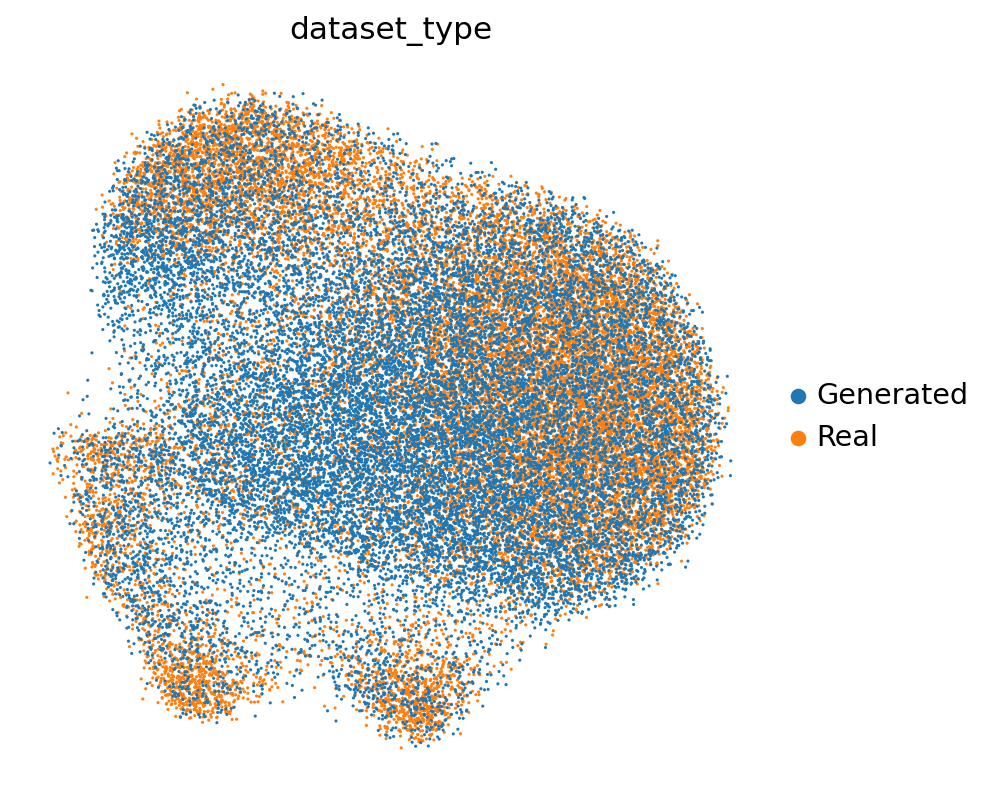

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


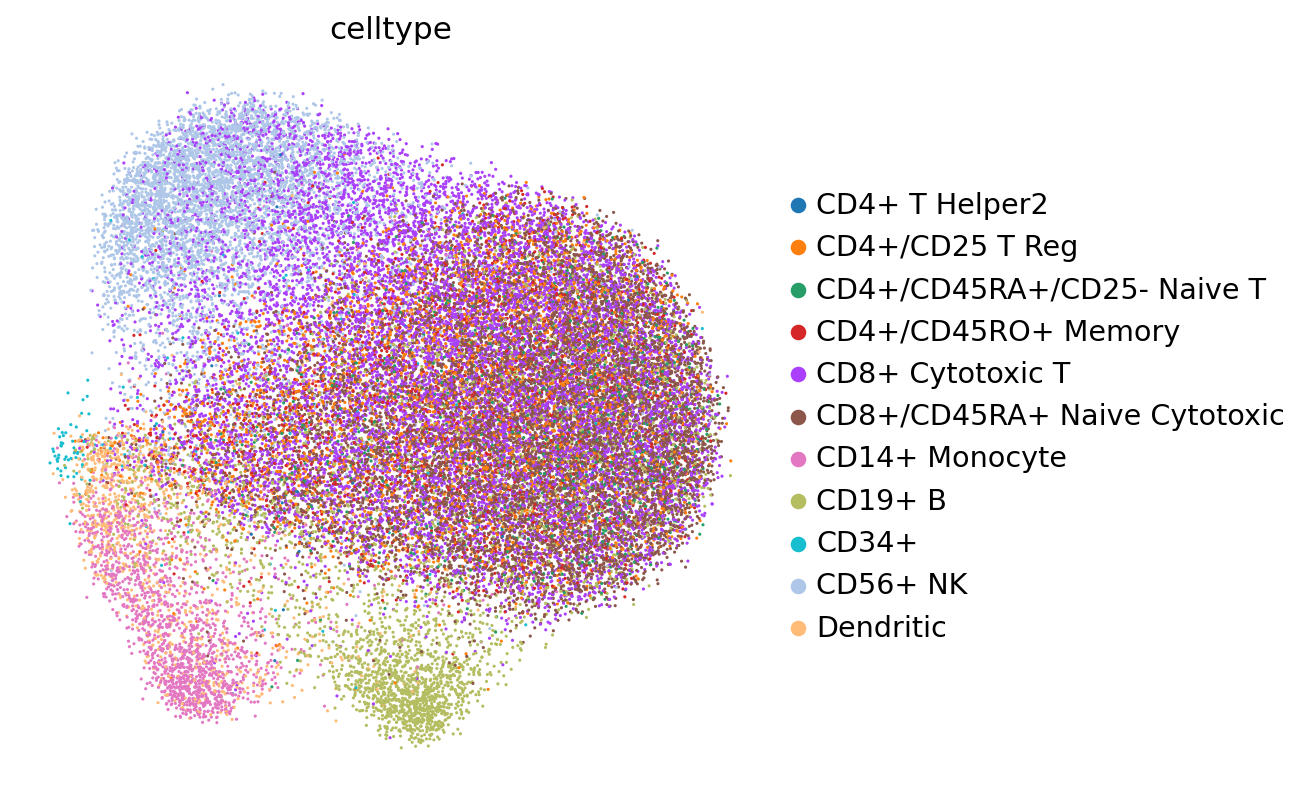

In [35]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True, s=8)
sc.pl.umap(adata_merged, color="dataset_type", s=8)
sc.pl.umap(adata_merged, color="celltype", s=8)

In [140]:
# sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color=["classes"], s=10, groups='CD14+ Monocyte')